In [1]:
!uv sync
import torch
import morphological_torch
import matplotlib.pyplot as plt
import timeit
from pytorch_semifield_conv import SelectSemifield, BroadcastSemifield
from pytorch_semifield_conv.convolutions.utils import ConvMeta
from src import load_data
from functools import partial
import math
import numpy as np
import polars as pl

from tqdm.auto import tqdm, trange

Resolved 163 packages in 0.72ms
Prepared 2 packages in 138ms                                             
Uninstalled 2 packages in 0.56ms
Installed 2 packages in 0.60ms=0.1.0 (from file:///home/pete
 ~ pytorch-numba-extension-jit==0.1.0 (from file:///home/peter/Thesis/pytorch-numba-extension-jit)
 ~ pytorch-semifield-conv==0.1.0 (from file:///home/peter/Thesis/pytorch-semifield-conv)


In [2]:
test_data = load_data.k_mnist().x_train[:4096].repeat((1, 6, 1, 1)).cuda()
test_data.shape

torch.Size([4096, 6, 28, 28])

In [3]:
INF = float("inf")
test_kernels = -torch.asarray(
    [
        # 1: Does nothing
        [[[INF, INF, INF], [INF, 0, INF], [INF, INF, INF]]],
        # 2: Vertical max
        [[[INF, 0, INF], [INF, 0, INF], [INF, 0, INF]]],
        # 3: Horizontal max
        [[[INF, INF, INF], [0, 0, 0], [INF, INF, INF]]],
        # 4: 3x3 max
        [[[0, 0, 0], [0, 0, 0], [0, 0, 0]]],
        # 5: small quadratic max, isotropic
        [[[0.4, 0.1, 0.4], [0.1, 0, 0.1], [0.4, 0.1, 0.4]]],
        # 6: small quadratic max, wide horizontally
        [[[0.5, 0.2, 0.5], [0.05, 0, 0.05], [0.5, 0.2, 0.5]]],
    ],
    device="cuda",
)
test_kernels.shape

torch.Size([6, 1, 3, 3])

In [12]:
unfold_dilate_copy = BroadcastSemifield.tropical_max().dynamic(unfold_copy=True)
unfold_dilate = BroadcastSemifield.tropical_max().dynamic()
unfold_dilate_spread = BroadcastSemifield.tropical_max(spread_gradient=True).dynamic()

In [5]:
# noinspection PyUnusedLocal
def rick_dilate(
        imgs, kernel, padding=None, stride=2, dilation=None, groups=None, kind=None
):
    return morphological_torch.pooling_autograd.ParameterizedMaxPool2DAutogradFunction.apply(
        imgs, kernel.squeeze(1), stride, 0
    )[0]

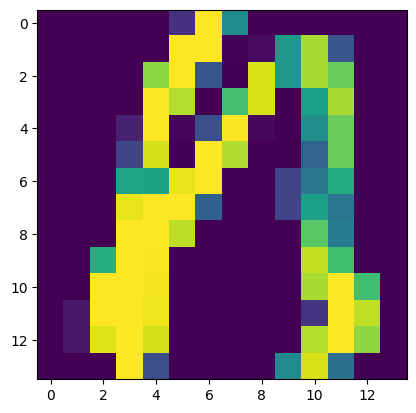

In [6]:
pool = morphological_torch.MaxPool2D(3)
plt.imshow(
    rick_dilate(test_data[:100], test_kernels.squeeze(1))[0][1].numpy(force=True)
)

In [7]:
unfold_dilate.semifield

BroadcastSemifield(add_reduce=<function _repeated_dim.<locals>.func at 0x7269d02060c0>, multiply=<function BroadcastSemifield.tropical_max.<locals>.<lambda> at 0x7269d0206160>, zero=-inf, add_reduce_channels=None)

In [8]:
test_results = []
test_grads_img = []
test_grads_kernel = []
for test_op in tqdm(
        (
                unfold_dilate,
                unfold_dilate_copy,
                SelectSemifield.tropical_max().lazy_fixed(),
                rick_dilate,
        )
):
    test_di = test_data[:4096].clone().requires_grad_(True)
    test_dk = test_kernels.clone().requires_grad_(True)
    test_res = test_op(test_di, test_dk, stride=1, padding=1, groups=6, kind="corr")
    test_results.append(test_res.clone().detach())
    test_res.sum().backward()
    test_grads_img.append(test_di.grad.clone())
    test_grads_kernel.append(test_dk.grad.clone())

  0%|          | 0/4 [00:00<?, ?it/s]

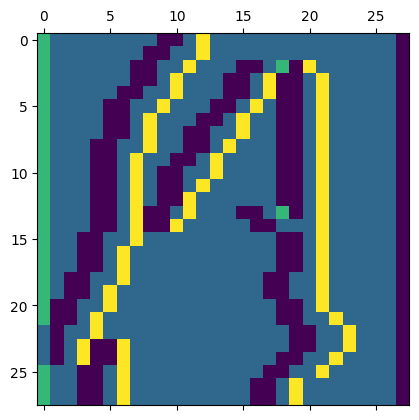

In [9]:
plt.matshow(test_grads_img[3][0, 2].numpy(force=True))

In [11]:
import itertools

for i0, i1 in itertools.product(range(len(test_results)), repeat=2):
    torch.allclose(test_results[i0], test_results[i1])
    torch.allclose(test_grads_img[i0], test_grads_img[i1])
    torch.allclose(test_grads_kernel[i0], test_grads_kernel[i1])

In [62]:
def get_timings_comparison(
        n_loops: int = 1_000,
        data: torch.Tensor = test_data,
        kernel: torch.Tensor = test_kernels,
        stride: int = 1,
        stop=23,
):
    padding = kernel.shape[2] // 2
    code = f"""
arr = dilate()
arr.backward(gradient)
sync() """

    def timer(glob, number=n_loops):
        return (
                timeit.timeit(
                    code,
                    number=number,
                    globals=glob,
                )
                / number
        )

    kernel = kernel.clone().requires_grad_(True)
    meta = ConvMeta.infer(
        tuple(data.shape), tuple(kernel.shape), stride, padding, groups=data.shape[1], kind="corr"
    )
    numba_dilate = SelectSemifield.tropical_max().compile(meta, to_extension=False)
    numba_dilate(data[:4], kernel)

    ext_dilate = SelectSemifield.tropical_max().compile(meta, to_extension=True)
    ext_dilate(data[:4], kernel)

    sizes = []
    unfold_times = []
    unfold_copy_times = []
    unfold_spread_times = []
    numba_times = []
    ext_times = []
    rick_times = []

    bar = trange(2, stop)

    # Warmup
    warmup_fun = lambda: ext_dilate(data[:1024], kernel)[0]
    timer(
        {
            "sync": torch.cuda.synchronize,
            "dilate": warmup_fun,
            "gradient": torch.rand_like(warmup_fun()),
        }
    )

    for log_size in bar:
        size = math.ceil(2 ** (log_size / 2))
        batch = data[:size].clone().requires_grad_(True)
        sizes.append(len(batch))
        bar.set_postfix(size=len(batch))

        gradient = torch.randn_like(ext_dilate(batch, kernel)[0])
        common_globals = {
            "sync": torch.cuda.synchronize,
            "gradient": gradient,
        }
        unfold_times.append(
            timer(
                common_globals
                | {
                    "dilate": partial(
                        unfold_dilate,
                        batch,
                        kernel,
                        padding=padding,
                        stride=stride,
                        groups=data.shape[1],
                        kind="corr",
                    )
                },
                number=n_loops if size > 64 else n_loops * 10,
            )
        )
        unfold_copy_times.append(
            timer(
                common_globals
                | {
                    "dilate": partial(
                        unfold_dilate_copy,
                        batch,
                        kernel,
                        padding=padding,
                        stride=stride,
                        groups=data.shape[1],
                        kind="corr",
                    )
                },
                number=n_loops // 2 if size > 64 else n_loops * 10,
            )
        )
        unfold_spread_times.append(
            timer(
                common_globals
                | {
                    "dilate": partial(
                        unfold_dilate_spread,
                        batch,
                        kernel,
                        padding=padding,
                        stride=stride,
                        groups=data.shape[1],
                        kind="corr",
                    )
                },
                number=n_loops if size > 64 else n_loops * 10,
            )
        )
        numba_times.append(
            timer(common_globals | {"dilate": lambda: numba_dilate(batch, kernel)[0]}
                  )
        )
        ext_times.append(
            timer(
                common_globals | {"dilate": lambda: ext_dilate(batch, kernel)[0]},
                number=n_loops if size > 64 else n_loops * 10,
            )
        )
        rick_times.append(
            timer(
                common_globals
                | {
                    "dilate": lambda: morphological_torch.pooling_autograd.ParameterizedMaxPool2DAutogradFunction.apply(
                        batch, kernel.squeeze(1), stride, 0
                    )[0]
                },
                number=n_loops // 30 if size > 64 else n_loops,
            )
        )

    # return sizes, unfold_times, numba_times, ext_times, rick_times
    return sizes, {
        "Unfold view": unfold_times,
        "Unfold copy": unfold_copy_times,
        "Unfold view + spread grad": unfold_spread_times,
        "Numba CUDA": numba_times,
        "PTX extension": ext_times,
        "Morphpool": rick_times,
    }

In [51]:
res = get_timings_comparison(n_loops=2_000)

  0%|          | 0/21 [00:00<?, ?it/s]

In [52]:
(pl.DataFrame(res[1] | {"sizes": res[0]}).write_parquet("./.data/new_timing_3_s1.pq"))

In [53]:
def plot_timings_comparison(
        sizes,
        lines: dict[str, list[float]],
        title="",
        skip_zoom=("Morphpool", "Numba CUDA"),
):
    fig, (ax_large, ax_zoom) = plt.subplots(
        ncols=2, layout="compressed", figsize=(10, 5)
    )
    ax_large: plt.Axes
    basic_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    ax_zoom.set_xlim(4, 128)
    ax_zoom.set_ylim(10 ** (-4.3), 10 ** (-3))
    ax_large.set_xscale("log", base=2)
    ax_large.set_yscale("log", base=10)
    ax_zoom.set_xscale("log", base=2)
    ax_zoom.set_yscale("log", base=10)
    for color, (name, vals) in zip(basic_colors, lines.items()):
        ax_large.plot(sizes, vals, label=name, color=color)
        ax_large.scatter(sizes, vals, color=color)
        if name not in skip_zoom:
            ax_zoom.plot(sizes, vals, label=name, color=color)
            ax_zoom.scatter(sizes, vals, color=color)

    ax_large.set_xlabel("Batch size (19 kB images)")
    ax_large.set_ylabel("Time (seconds)")
    ax_zoom.set_xlabel("Batch size (19 kB images)")
    ax_zoom.set_ylabel("Time (seconds)")
    ax_large.set_title("Full measurements")
    ax_zoom.set_title("Zoomed on low values")
    fig.suptitle(title)
    ax_large.legend()
    ax_zoom.legend()
    fig.show()

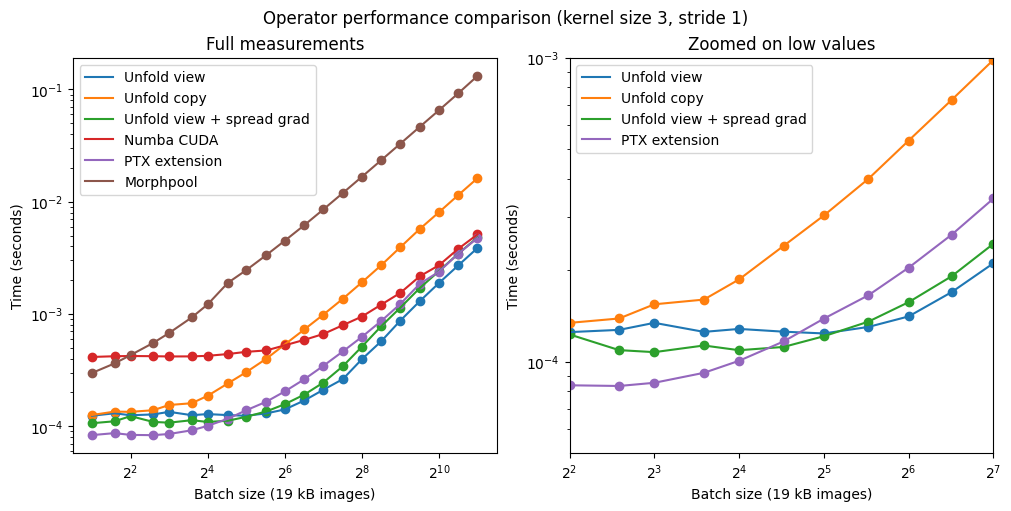

In [54]:
plot_timings_comparison(
    *res, title="Operator performance comparison (kernel size 3, stride 1)"
)

In [59]:
res_s2 = get_timings_comparison(stride=2)

  0%|          | 0/21 [00:00<?, ?it/s]

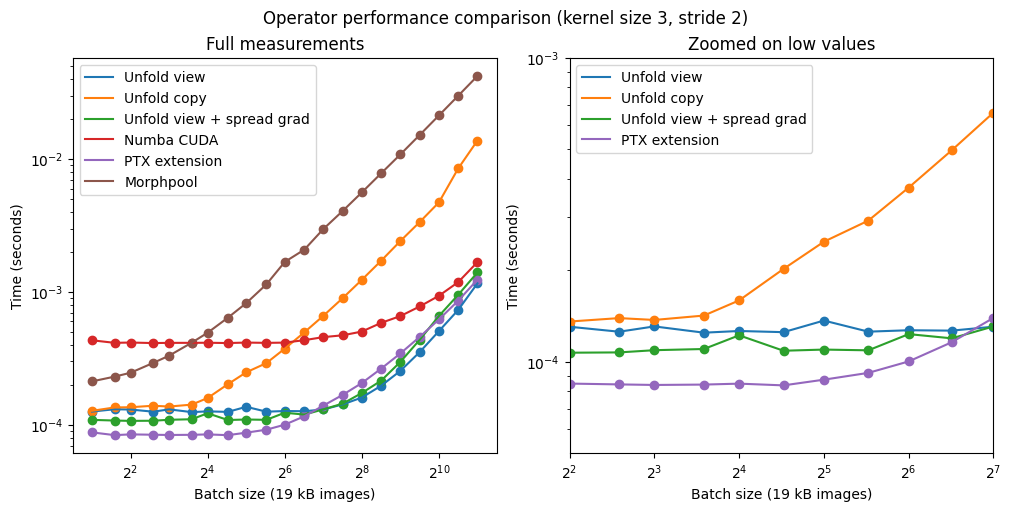

In [60]:
plot_timings_comparison(
    *res_s2, title="Operator performance comparison (kernel size 3, stride 2)"
)

In [63]:
test_kernels_7 = torch.randn((6, 1, 7, 7), device="cuda")
test_kernels_7.shape

torch.Size([6, 1, 7, 7])

In [64]:
res7_s2 = get_timings_comparison(kernel=test_kernels_7, stride=2)

  0%|          | 0/21 [00:00<?, ?it/s]

<timeit-src>:7: UserWarning: Convolution parameters changed
<timeit-src>:7: UserWarning: Convolution parameters changed
<timeit-src>:7: UserWarning: Convolution parameters changed


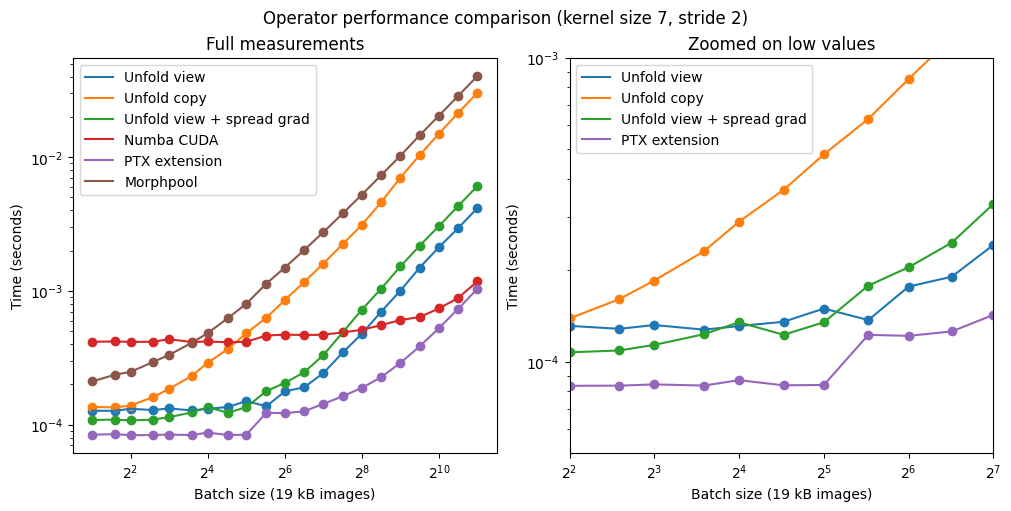

In [66]:
plot_timings_comparison(
    *res7_s2, title="Operator performance comparison (kernel size 7, stride 2)"
)